# 1. Problem presentation 

This notebook illustrates in a simple way that for a dynamical system very sparsely observed, using an advanced data assimilation method (here, an Ensemble Kalman filter, EnKF) rather than a crude one (here, direct substitution of the observed variable with the observation) is essential to estimate the system.

The illustration uses the 3-variable, chaotic Lorenz 63 system (https://en.wikipedia.org/wiki/Lorenz_system). This dynamical model is often used to test data assimilation methods, because it displays a chaotic behavior, as the atmosphere and the ocean do, with very low dimensionality.

We consider the Lorenz equations :

\begin{equation} 
\begin{aligned} \frac{dx}{dt} & = \sigma(y-x) \\ \frac{dy}{dt} & = \rho x - y - xz \\ \frac{dz}{dt} & = -\beta z + xy \end{aligned} 
\end{equation} 

This system is a non-linear differential system of order 1. Using the following parameters, $\sigma=10$, $\beta=\frac{8}{3}$, $\rho=28.0$, it gives rise to a chaotic system. the solution is seen to orbit around two equilibrium points giving two 'regimes'.

In the sequel we will denote the model variable $u = (x, y, z)$, and $u_0 = (x_0,y_0,z_0)$ the initial condition.

The main steps covered below are:
- Simulation and plots of the Lorenz model
- Test model's sensitivity to changes in initial condition and a model parameter
- Experiment assimilation of observation drawn from the reference trajectory into the model with changed initial condition and parameter: direct substitution, and Ensemble Kalman filtering


In [1]:
%matplotlib nbagg
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.colors import cnames
import matplotlib.animation as animation

## 1.1 Simulation and plots

Let us start by defining a Python function that calculates and draws the trajectory of a particule whose position is defined by the Lorenz equation. This function takes as input the parameters of the Lorenz system ($\sigma$, $\beta$, $\rho$), the initialisation (x0, y0, z0), the temporal window  (max_time) and the visualisation angle (angle).


In [2]:
def solve_lorenz(max_time=4.0, deltat=1/100., sigma=10.0, beta=8./3, rho=28.0, x0=10., y0=20.,z0=10.5):

    deltat = 1/100.
    res = int(max_time / deltat)
    
    x = np.zeros((res+1))
    y = np.zeros((res+1))
    z = np.zeros((res+1))
      
    x[0]= x0
    y[0]=y0
    z[0]=z0
    for t in range(0,res):
        x[t+1] = x[t]+deltat*sigma*(y[t]-x[t]) 
        y[t+1] = y[t]+deltat*(rho*x[t]-y[t]-x[t]*z[t]) 
        z[t+1] = z[t]+deltat*(-beta*z[t]+x[t]*y[t]) 

    return x, y, z
    
    
def draw_lorenz(angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0,  x0=10., y0=20.,z0=10.5):
    
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_title('Lorenz attractor')

    x, y, z = solve_lorenz(max_time=max_time, sigma=sigma, beta=beta, rho=rho,  x0=x0, y0=y0,z0=z0)
    lines = ax.plot(x, y, z, '-')
    plt.setp(lines, linewidth=2)
    
    ax.view_init(30, angle)
    plt.show()

    f, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(x, label='x')
    axarr[0].legend(loc="upper right")
    axarr[1].plot(y, label='y')
    axarr[1].legend()
    axarr[2].plot(z, label='z')
    axarr[2].legend()
    
    return 

<IPython.core.display.Javascript object>


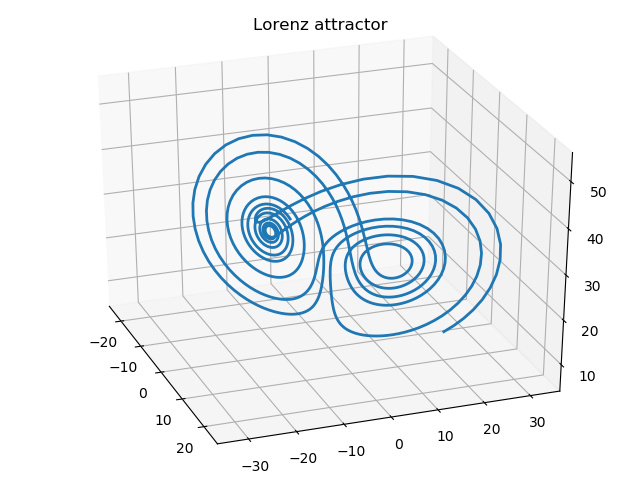

<IPython.core.display.Javascript object>


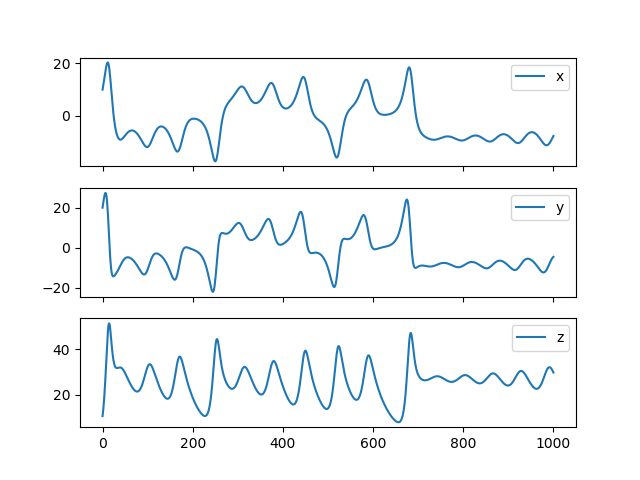

In [3]:
draw_lorenz(angle=-20.0, max_time=10.)

## 1.2 Animation

In [4]:
def stack_lorenz(solve,max_time=4.0, sigma=10.0, beta=8./3, rho=28.0, x0=10., y0=20.,z0=10.5):
    x, y, z = solve(max_time=max_time,sigma=sigma, beta=beta,rho=rho,x0=x0, y0=y0,z0=z0)
    
    res = int(100 * max_time)

    data=np.empty((3,res+1))
    data[0,:]=x[:]
    data[1,:]=y[:]
    data[2,:]=z[:]
    return data

def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

<IPython.core.display.Javascript object>


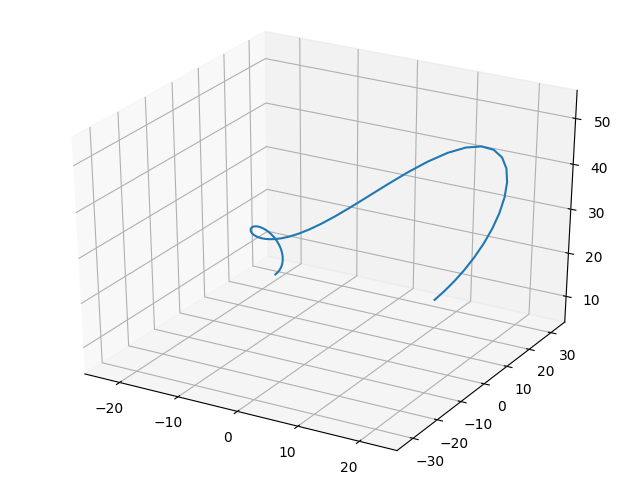

In [5]:

max_time = 10.0

fig = plt.figure()
ax  = p3.Axes3D(fig)

ax.set_xlim3d((-25., 25.))
ax.set_ylim3d((-35., 35.))
ax.set_zlim3d((5., 55.))

data = [stack_lorenz(solve_lorenz,max_time=max_time)]

lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

line_ani = animation.FuncAnimation(fig, update_lines, 1001, fargs=(data, lines),
                                   interval=50, blit=False)

--------------------------------------------------------------------------------------------------

# 2. Reference simulation and perturbation

Use the following lines to study the sensibility of the solution to inaccurate initial condition and/or inaccurate parameters


## 2.1 Lorenz model with inaccurate initial condition

In [5]:
def draw_lorenz_comparison(angle=-20.0, max_time=10.0, sigma_ref=10.0, beta_ref=8./3, rho_ref=28.0,  
                           x0_ref=10., y0_ref=20.,z0_ref=10.5,
                           sigma_inac=10.0, beta_inac=8./3, rho_inac=28.0,  
                           x0_inac=10., y0_inac=20.,z0_inac=10.5):
    
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_title('Lorenz attractor')

    x_ref, y_ref, z_ref = solve_lorenz(max_time=max_time, sigma=sigma_ref, beta=beta_ref, rho=rho_ref,
                                x0=x0_ref, y0=y0_ref,z0=z0_ref)
    x_inac,y_inac,z_inac = solve_lorenz(max_time=max_time, sigma=sigma_inac, beta=beta_inac, rho=rho_inac,
                                x0=x0_inac, y0=y0_inac,z0=z0_inac)
    lines_ref = ax.plot(x_ref, y_ref, z_ref, '-')
    lines_inac = ax.plot(x_inac, y_inac, z_inac, '-')
    plt.setp(lines_ref, linewidth=2,label='reference')
    plt.setp(lines_inac, linewidth=2,label='inacurrate')
    ax.view_init(30, angle)
    plt.show()
    plt.legend()

    f, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(x_ref, label='x reference')
    axarr[0].plot(x_inac, label='x inacurrate')
    axarr[0].legend(loc="upper right")
    axarr[1].plot(y_ref, label='y reference')
    axarr[1].plot(y_inac, label='y inacurrate')
    axarr[1].legend(loc="upper right")
    axarr[2].plot(z_ref, label='z reference')
    axarr[2].plot(z_inac, label='z inacurrate')
    axarr[2].legend(loc="upper right")
    
    return 

<IPython.core.display.Javascript object>


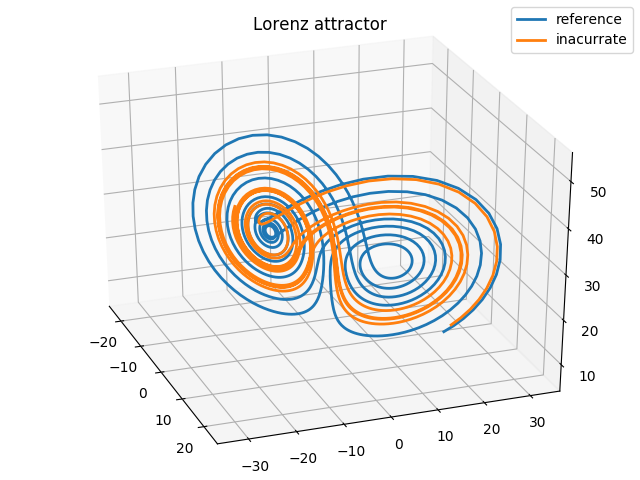

<IPython.core.display.Javascript object>


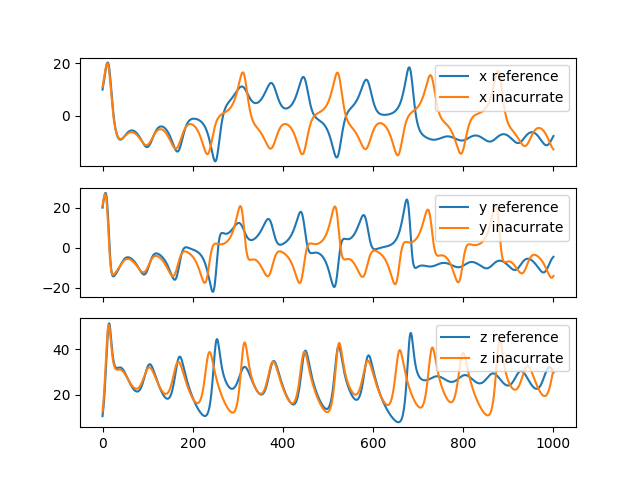

In [7]:
draw_lorenz_comparison(x0_inac=11., y0_inac=21.,z0_inac=12.5)



## 2.2 Lorenz model with inaccurate parameters


<IPython.core.display.Javascript object>


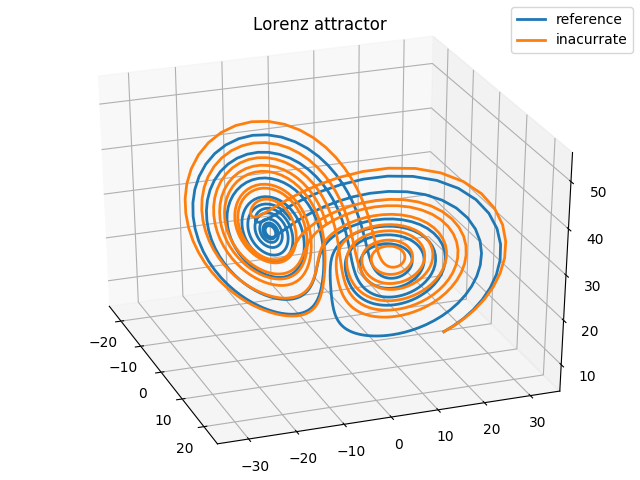

<IPython.core.display.Javascript object>


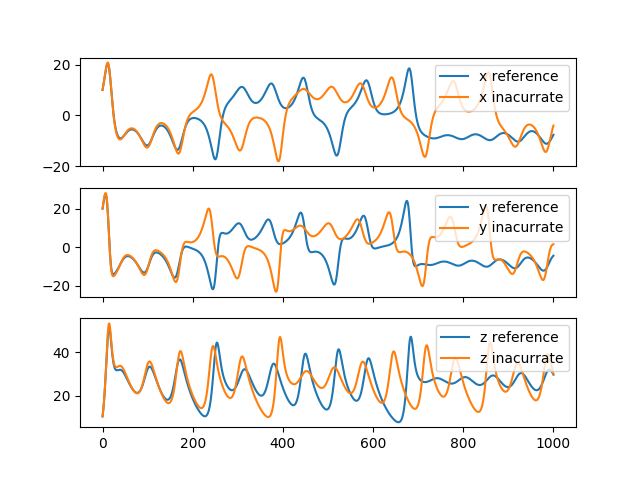

In [8]:
draw_lorenz_comparison(sigma_inac=10.0, beta_inac=8./3, rho_inac=29.0)

## 2.3 Lorenz model with inaccurate conditions and inaccurate parameters

<IPython.core.display.Javascript object>


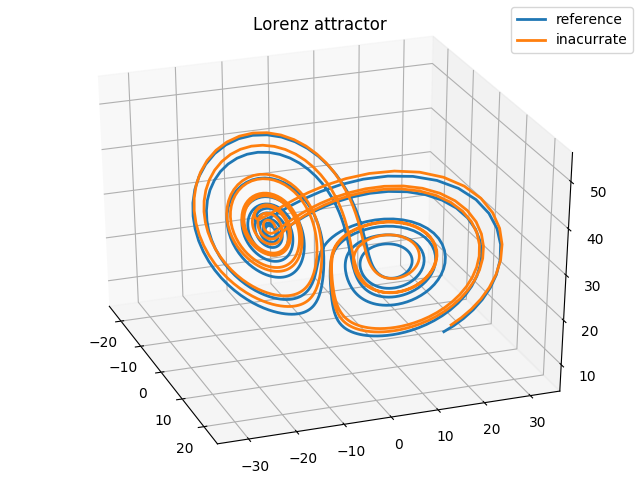

<IPython.core.display.Javascript object>


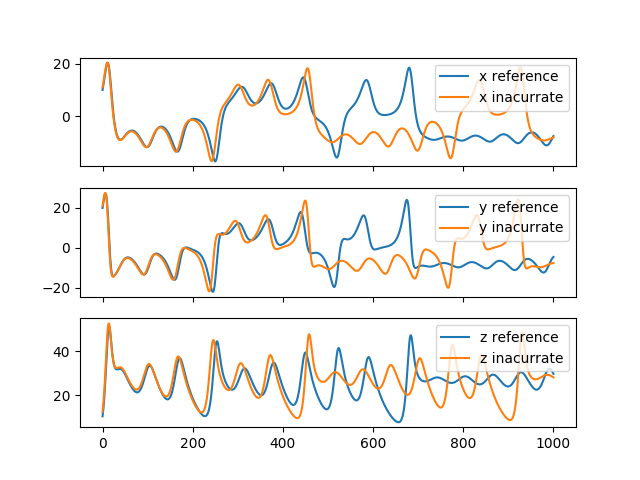

In [9]:
draw_lorenz_comparison(sigma_inac=10.0, beta_inac=8./3, rho_inac=29.0, x0_inac=11., y0_inac=21.,z0_inac=12.5)

---------------------------------------------------------------------------------------

# 3. Data assimilation

We now turn to data assimilation. To do so, we will perform twin experiments.
We assume our model is inaccurate, and the initial condition is not perfectly known. To mimic this, we assimilate observations extracted from the reference simulation ($\rho=28$, initial condition = (1.5, -1.5, 21) ) into an unperfect model ($\rho=29$) initialized with unperfect conditions : the background is set to (3, -3, 21).

We first consider the case where ALL variables (x, but also y and z) are observed at all times.

In [6]:
# Timeline
t = 6                                         # end of time window
dt = 1/100.                                   # time step
times = np.arange(0,t,dt)
res = times.size                              # number of iterations

# Observation extracted from reference simulation
x_obs, y_obs, z_obs = solve_lorenz(max_time=t, deltat=dt, x0=1.5, y0=-1.5, z0=21)

# We suppose an inaccurate system:
# Background(initialized unperfect condition)
x_b = 3
y_b = -3
z_b = 21

# Unperfected model
sigma_un = 10
beta_un = 8/3.0
rho_un = 29.0

# If we trust the observtions and all variables are observed,
# in one step we go the the real solution

## 3.1 First data assimilation experiment: Extended Kalman filter
Implement the Extended Kalman filter algorithm, and validate it in the twin experiments framework: initialise the algorithm with the background, use the observations, and check that your analysis $u_a$ is a good approximation of the exact solution $u_{ref}$. Provide figures to illustrate this point (at least one figure showing the evolution of the reference, the background and the analysis trajectories during the time window [0, 4]).

Let $\tau$ be a small time step. At any time $t$, we have the following piecewise-linear approximation:

$$
u(t + \tau) = u(t) + u'(t) \tau
$$

Let $\mathcal M$ denote the (stationary) model operator which, for a given state $u(t)$ at time $t$, outputs an estimation of the state $u(t + \tau)$ at time $t + \tau$. Let $(\sigma, \beta, \rho)$ be the parameters of this unperfect model and $f$ denote the function which, for all $u=(x, y, z) \in \mathbb{R}^3$, gives:

$$
f(u) =
\begin{bmatrix}
    \sigma (y-x) \\
    \rho x - y - xz \\
    -\beta z + xy
\end{bmatrix}
$$

For all $t$, we have: $f[u(t)] = u'(t)$. Then, for all $u \in \mathbb{R}^3$, the Lorenz equations write:

$$
\mathcal M(u) = u + f(u) \tau
$$

### Computation of the tangent linear model of $\mathcal M$

For each state $u$, let $M_{[u]}$ denote the tangent linear model (i.e. the Jacobian matrix) of $\mathcal M$ applied to $u$:

$$M_{[u]} = I + F_{[u]} \tau$$
where $F_{[u]}$ is the Jacobian matrix of $f$ applied to $u$. Then we get:

$$
M_{[u]} = 
\begin{bmatrix}
    1 - \sigma \tau & \sigma \tau & 0 \\
    (\rho - z) \tau & 1 - \tau & -x \tau \\
    y \tau & x \tau & 1 - \beta \tau
\end{bmatrix}
$$

### Estimation of the model error covariance matrix

For any state $u \in \mathbb R^3$, let $Q_u$ be the model error covariance matrix of $\mathcal M$ applied to $u$.

Let $\overline{\mathcal M}$ be the perfect model with unknown parameters $(\overline \sigma, \overline \beta, \overline \rho)$ and $\varepsilon^m(u)$ be the model error applied to $u$. Then we have:

$$
\begin{split}
\varepsilon^m(u)
    & = \mathcal M(u) - \overline{\mathcal M}(u) \\
    & = \left(f(u) - \overline f(u) \right) \tau \\
    & = \begin{bmatrix}
        \varepsilon^\sigma (y-x) \\
        \varepsilon^\rho x \\
        -\varepsilon^\beta z
    \end{bmatrix} \tau
\end{split}
$$

where $\left(\varepsilon^\sigma = \sigma - \overline \sigma \right)$, $\left(\varepsilon^\beta = \beta - \overline \beta \right)$ and $\left(\varepsilon^\rho = \rho - \overline \rho \right)$ denote the errors made over the parameters. The model error covariance matrix writes:

$$
\begin{split}
    Q_u
        & = \begin{bmatrix}
            (y-x)^2 \mbox{ Var}(\varepsilon^\sigma) & (y-x)x \mbox{ Cov}(\varepsilon^\sigma, \varepsilon^\rho) & -(y-x)z \mbox{ Cov}(\varepsilon^\sigma, \varepsilon^\beta) \\
            (y-x)x \mbox{ Cov}(\varepsilon^\rho, \varepsilon^\sigma) & x^2 \mbox{ Var}(\varepsilon^\rho) & -xz \mbox{ Cov}(\varepsilon^\rho, \varepsilon^\beta) \\
            -(y-x)z \mbox{ Cov}(\varepsilon^\beta, \varepsilon^\sigma) & -xz \mbox{ Cov}(\varepsilon^\beta, \varepsilon^\rho) & z^2 \mbox{ Var}(\varepsilon^\beta)
        \end{bmatrix} \tau^2
\end{split}
$$

Let's assume that:
- The variance of the errors made over each parameter is of order of magnitude $1$;
- The errors made over two different parameters are independant; thus $Q_u$ is a diagonal matrix.

Then we get:

$$Q_u \sim \begin{bmatrix}
    (y-x)^2 & 0 & 0 \\
    0 & x^2 & 0 \\
    0 & 0 & z^2
\end{bmatrix} \tau^2$$


### Estimation of the background error and observation error covariance matrices

Let $P^b$ denote the background error covariance matrix (i.e. the covariance matrix of the system at time $t=0$) and $R$ denote the observation error covariance matrix. Since all variables are observed, we have: $R \in \mathbb R^{3 \times 3}$.

Let's assume that the errors made over two different variables ($x$, $y$ or $z$) are independant. Thus $P^b$ and $R$ are diagonal matrices. In first approach, we consider the identity matrix for both $P^b$ and $R$.

In [7]:
def model(u_inp, sigma, beta, rho, dt):
    """
    Model defined by 3 parameters sigma, beta and rho.
    For a given input state u_inp at time t, returns the state of the system u_mod at time t + dt.
    The model is linearized between t and t + dt.

    Inputs:
    - u_inp (vector of size 3):       state of the system at time t
    - sigma, beta, rho:               model parameters
    - dt:                             time step

    Outputs:
    - u_mod (vector of size 3):       state of the system at time t + dt, by applying the model

    """
    du1 = (sigma * (u_inp[1] - u_inp[0])) * dt
    du2 = (rho * u_inp[0] - u_inp[1] - u_inp[0] * u_inp[2]) * dt
    du3 = (-beta * u_inp[2] + u_inp[0] * u_inp[1]) * dt
    u_mod = u_inp + np.array([du1, du2, du3])
    
    return u_mod


def ext_kalman_forecast(u_inp, P_inp, Q, M, sigma, beta, rho, dt):
    """
    Forecast step of the extended Kalman filter.

    Inputs:
    - u_inp (vector of size 3):        state of the system estimated at time t (analysis step)
    - P_inp (array of shape (3, 3)):   covariance matrix of the system estimated at time t (analysis step)
    - Q (array of shape (3, 3)):       covariance matrix of the model error at time t
    - M (array of shape (3, 3)):       tangent linear model of the model at time t, applied to the input state u_inp
    - sigma, beta, rho:                model parameters
    - dt:                              time step

    Outputs:
    - u_for (vector of size 3):        state of the system estimated at time t + dt (forecast step)
    - P_for (array of shape (3, 3)):   covariance matrix of the system estimated at time t + dt (forecast step)

    """
    u_for = model(u_inp, sigma, beta, rho, dt)
    P_for = M.dot(P_inp.dot(M.T)) + Q
    
    return u_for, P_for


def ext_kalman_analysis(u_for, P_for, obs, R, H):
    """
    Analysis step of the extended Kalman filter.

    Inputs:
    - u_for (vector of size 3):       state of the system estimated after forecast step (at time t + dt)
    - P_for (array of shape (3, 3)):  covariance matrix of the system estimated after forecast step (at time t + dt)
    - obs (vector of size 3):         observation at time t + dt
    - R (array of shape (3, 3)):      covariance matrix of the observation error at time t + dt
    - H (array of shape (3, 3)):      tangent linear model of the observation at time t + dt, applied to u_for

    Outputs:
    - u_ana (vector of size 3):       state of the system estimated after analysis step (at time t + dt)
    - P_ana (array of shape (3, 3)):  covariance matrix of the system estimated after analysis step (at time t + dt)

    """
    dim = u_for.size                                                          # dim = 3 in this problem

    #if np.linalg.norm(R) == 0:                                                # Perfect Observations
    #    K = np.linalg.inv(H)                                                  # Kalman Gain (simplified)
    #else:
    #    K = (P_for.dot(H.T)).dot(np.linalg.inv(R + H.dot(P_for.dot(H.T))))    # Kalman Gain (full)
    
    K = (P_for.dot(H.T)).dot(np.linalg.inv(R + H.dot(P_for.dot(H.T))))        # Kalman Gain

    P_ana = (np.eye(dim) - K.dot(H)).dot(P_for)                               # covariance matrix of the system

    innovation = obs - H.dot(u_for)
    u_ana = u_for + K.dot(innovation)                                         # State vector

    return u_ana, P_ana


def kalman_2steps(u_inp, P_inp, Q, M, obs, R, H, sigma, beta, rho, dt):
    """
    One iteration of the extended Kalman filter, composed of the forecast step and the analysis step.

    Inputs:
    - u_inp (vector of size 3):        state of the system estimated at time t (analysis step)
    - P_inp (array of shape (3, 3)):   covariance matrix of the system estimated at time t (analysis step)
    - Q (array of shape (3, 3)):       covariance matrix of the model error at time t
    - M (array of shape (3, 3)):       tangent linear model of the model at time t, applied to the input state u_inp
    - obs (vector of size 3):          observation at time t + dt
    - R (array of shape (3, 3)):       covariance matrix of the observation error at time t + dt
    - H (array of shape (3, 3)):       tangent linear model of the observation at time t + dt, applied to u_for
    - sigma, beta, rho:                model parameters
    - dt:                              time step

    Outputs:
    - u_ana (vector of size 3):        state of the system estimated after analysis step (at time t + dt)
    - P_ana (array of shape (3, 3)):   covariance matrix of the system estimated after analysis step (at time t + dt)

    """
    u_for, P_for = ext_kalman_forecast(u_inp, P_inp, Q, M, sigma, beta, rho, dt)
    u_ana, P_ana = ext_kalman_analysis(u_for, P_for, obs, R, H)

    return u_ana, P_ana


def model_error_cov_matrix(u_inp, dt, var=1):
    """
    Returns the model error covariance matrix applied to a given input at time t.
    
    Inputs:
    - u_inp (vector of size 3):        state of the system estimated at time t (analysis step)
    - dt:                              time step
    - var (default = 1):               variance of the errors made over the parameters of the model
    
    Outputs:
    - Q:                               model error covariance matrix
    
    """
    Q = np.array([
        [(u_inp[1]-u_inp[0])**2, 0, 0],
        [0, u_inp[0]**2, 0],
        [0, 0, u_inp[2]**2]
    ]) * var * dt**2
    
    return Q

In [8]:
# Initialisation
background = np.array([x_b, y_b, z_b])        # initial value, starting point
u = background

# Background error covariance matrix
variance_bac = 2
P = variance_bac * np.eye(3)                  # identity matrix (times scalar)

# Model error covariance matrix
variance_mod = 1
Q = model_error_cov_matrix(u, dt, var=variance_mod)

# Observation operator
H = np.eye(3)                                 # all variables are observed

# Observation error covariance matrix
variance_obs = 1
R = variance_obs * np.eye(3)                  # identity matrix (times scalar)

# Array where the solution is stored
x_kal = np.zeros(res+1)
y_kal = np.zeros(res+1)
z_kal = np.zeros(res+1)

x_kal[0] = u[0]                                # initial state
y_kal[0] = u[1]                                # initial state
z_kal[0] = u[2]                                # initial state

# Steps of Extended Kalman filter
for k in range(0,res):
    
    # Tangent linear model at times[k]
    M = np.array([
        [1-sigma_un*dt, sigma_un*dt, 0],
        [(rho_un-u[2])*dt, 1-dt, -u[0]*dt],
        [u[1]*dt, u[0]*dt, 1-beta_un*dt]
    ])
    
    # Observation at times[k+1] (after forecast step)
    obs = np.array([x_obs[k+1], y_obs[k+1], z_obs[k+1]])
    
    # Run one 2-step-iteration of the extended Kalman filter and record the new state
    u, P = kalman_2steps(u, P, Q, M, obs, R, H, sigma_un, beta_un, rho_un, dt)
    x_kal[k+1]=u[0]
    y_kal[k+1]=u[1]
    z_kal[k+1]=u[2]
    
    # Compute the new model error covariance matrix:
    Q = model_error_cov_matrix(u, dt, var=variance_mod)

<IPython.core.display.Javascript object>


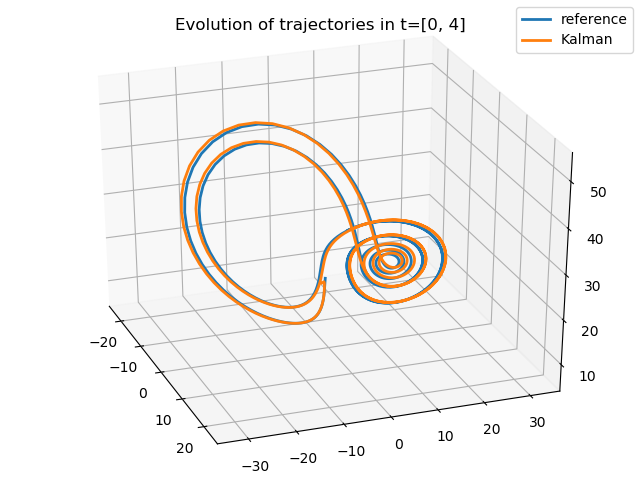

<IPython.core.display.Javascript object>


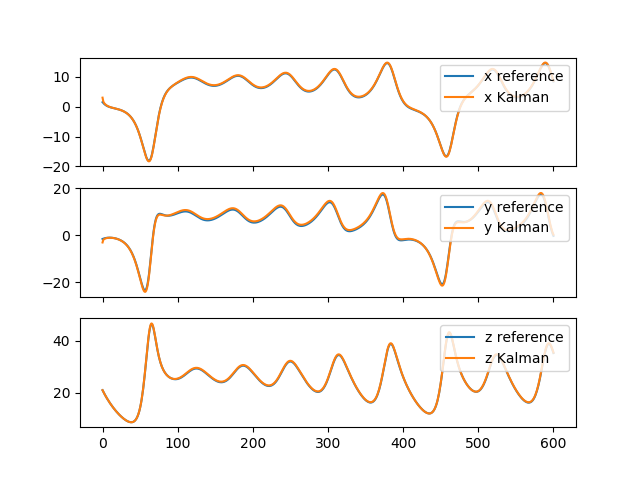

In [9]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('Evolution of trajectories in t=[0, 4]')

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_kal = ax.plot(x_kal, y_kal, z_kal, '-')
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_kal, linewidth=2,label='Kalman')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(x_kal, label='x Kalman')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(y_kal, label='y Kalman')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(z_kal, label='z Kalman')
axarr[2].legend(loc="upper right")

## 3.2 Second data assimilation experiment: Ensemble Kalman filter
We perform the same experiment as above, same model, same observations, but with an Ensemble Kalman filter (EnKF). The EnKF is a Monte Carlo method, therefore requires the definition of an ensemble (sample) size. An estimation of the observation error variance is also needed.

In [10]:
def model(u_inp, sigma, beta, rho, dt):
    """
    Model defined by 3 parameters sigma, beta and rho.
    For a given input state u_inp at time t, returns the state of the system u_mod at time t + dt.
    The model is linearized between t and t + dt.

    Inputs:
    - u_inp (vector of size 3):       state of the system at time t
    - sigma, beta, rho:               model parameters
    - dt:                             time step

    Outputs:
    - u_mod (vector of size 3):       state of the system at time t + dt, by applying the model

    """
    du1 = (sigma * (u_inp[1] - u_inp[0])) * dt
    du2 = (rho * u_inp[0] - u_inp[1] - u_inp[0] * u_inp[2]) * dt
    du3 = (-beta * u_inp[2] + u_inp[0] * u_inp[1]) * dt
    u_mod = u_inp + np.array([du1, du2, du3])
    
    return u_mod


def ensemble_kalman_initialization(u, P, N):
    """
    Given a background state u, outputs a sample (ensemble) of N state vectors around u.
    The background error is assumed to follow a normal distribution with mean 0 and covariance P
    
    Inputs:
    - u (vector of size 3):        background state
    - P (array of shape (3, 3)):   background error covariance matrix
    - N:                           number of members in the ensemble
    
    Outputs:
    - U (array of shape (N, 3)):   array containing the ensemble (each row is a member of the ensemble)
    
    """
    #U = np.zeros((N, u.size))
    #for i in range (N):
    #    U[i,:] = np.random.multivariate_normal(u, P)
    U = np.random.multivariate_normal(u, P, N)
    return U

        
def ensemble_kalman_forecast(U_inp, P_inp, sigma, beta, rho, dt, inflation=1):
    """
    Forecast step of the ensemble Kalman filter.

    Inputs:
    - U_inp (array of shape (N, 3)):   ensemble estimated at time t (analysis step)
    - P_inp (array of shape (3, 3)):   covariance matrix of the system estimated at time t (analysis step)
    - sigma, beta, rho:                model parameters
    - dt:                              time step

    Outputs:
    - U_for (array of shape (N, 3)):   ensemble estimated at time t + dt (forecast step)
    - Ubar (vector of size 3):         expected state vetor at time t + dt (forecast step)
    - P_for (array of shape (3, 3)):   covariance matrix of the system estimated at time t + dt (forecast step)

    """
    N = U_inp.shape[0]                               # Number of members in the ensemble
    dim = U_inp.shape[1]                             # In this problem, dim = 3
    
    # Ensemble estimated at time t + dt by applying the model to each of its members
    U_for = np.zeros((N, dim))
    for i in range (N):
        U_for[i,:] = model(U_inp[i,:], sigma, beta, rho, dt)
    
    # Expected state vector at time t + dt
    Ubar = sum(U_for)/N
    
    # Covariance matrix of the system estimated at time t + dt
    P_for = np.zeros((dim, dim))
    for i in range (N):
        P_for += np.outer(U_for[i,:] - Ubar, U_for[i,:] - Ubar)
    P_for = inflation**2 * P_for/(N-1)
    
    return U_for, Ubar, P_for


def ensemble_kalman_analysis(U_for, Ubar, P_for, obs, R, H, inflation=1):
    """
    Analysis step of the ensemble Kalman filter.

    Inputs:
    - U_for (array of shape (N, 3)):  ensemble estimated after forecast step (at time t + dt)
    - P_for (array of shape (3, 3)):  covariance matrix of the system estimated after forecast step (at time t + dt)
    - obs (vector of size 3):         observation at time t + dt
    - R (array of shape (3, 3)):      covariance matrix of the observation error at time t + dt
    - H (array of shape (3, 3)):      observation operator (assumed linear in this problem)

    Outputs:
    - U_ana (vector of size 3):       ensemble estimated after analysis step (at time t + dt)

    """
    N = U_for.shape[0]                               # Number of members in the ensemble
    dim = U_for.shape[1]                             # In this problem, dim = 3
    
    # Computation of intermediate arrays:
    PHT = np.zeros((dim,dim))
    HPHT = np.zeros((dim,dim))
    for i in range (N):
        PHT += np.outer(U_for[i,:] - Ubar, H.dot(U_for[i,:]) - H.dot(Ubar))
        HPHT += np.outer(H.dot(U_for[i,:]) - H.dot(Ubar), H.dot(U_for[i,:]) - H.dot(Ubar))
    PHT = inflation**2 * PHT/(N-1)
    HPHT = inflation**2 * HPHT/(N-1)
    
    #if np.linalg.norm (HPHT + R, 2) <= 0.0001:       # Below this value, the observations are considered perfect
    #    K = np.linalg.inv(H)                         # Kalman Gain (simplified)
    #else:
    #    K = PHT*np.linalg.inv(R + HPHT)              # Kalman Gain (full)
    
    #for i in range (N):
    #    U_ana[i,:] = U_for[i,:] + K.dot(obs - H.dot(U_for[i,:])) # State vector
    
    K = PHT.dot(np.linalg.inv(HPHT + R))             # Kalman Gain
    OBS = np.random.multivariate_normal(obs, R, N)   # Sampling simulated observations from the real observation
    U_ana = U_for + (OBS - U_for.dot(H.T)).dot(K.T)  # Ensemble after analysis step
    
    P_ana = P_for # No update of the covariance matrix at analysis step
        
    return U_ana, P_ana


def enskalman_2steps(U_inp, P_inp, obs, R, H, sigma, beta, rho, dt, inflation=1):
    """
    One iteration of the ensemble Kalman filter, composed of the forecast step and the analysis step.

    Inputs:
    - u_inp (vector of size 3):        ensemble estimated at time t (analysis step)
    - P_inp (array of shape (3, 3)):   covariance matrix of the system estimated at time t (analysis step)
    - obs (vector of size 3):          observation at time t + dt
    - R (array of shape (3, 3)):       covariance matrix of the observation error at time t + dt
    - H (array of shape (3, 3)):       observation operator (assumed linear in this problem)
    - sigma, beta, rho:                model parameters
    - dt:                              time step

    Outputs:
    - u_ana (vector of size 3):        state of the system estimated after analysis step (at time t + dt)
    - P_ana (array of shape (3, 3)):   covariance matrix of the system estimated after analysis step (at time t + dt)

    """
    U_for, Ubar, P_for = ensemble_kalman_forecast(U_inp, P_inp, sigma, beta, rho, dt, inflation=inflation)
    U_ana, P_ana = ensemble_kalman_analysis(U_for, Ubar, P_for, obs, R, H, inflation=inflation)
    
    return U_ana, P_ana

In [11]:
# Initialisation
N = 20                                             # number of members in the ensemble
background = np.array([x_b, y_b, z_b])             # initial value, starting point
u = background

# Background error covariance matrix
variance_bac = 2
P = variance_bac * np.eye(3)                       # identity matrix (times scalar)

# Observation operator
H = np.eye(3)                                      # all variables are observed

# Observation error covariance matrix
variance_obs = 2
R = variance_obs * np.eye(3)                       # identity matrix (times scalar)

# Matrices where the ensembles are stored
X_kal = np.zeros((N, res+1))
Y_kal = np.zeros((N, res+1))
Z_kal = np.zeros((N, res+1))

U = np.random.multivariate_normal(u, P, N)         # first sampling (ensemble at t=0)

# initial ensembles
X_kal[:,0] = U[:,0]
Y_kal[:,0] = U[:,1]
Z_kal[:,0] = U[:,2]

# steps of Ensemble Kalman Filter
for k in range(0,res):
    
    # Observation at times[k+1] (after forecast step)
    obs = np.array([x_obs[k+1], y_obs[k+1], z_obs[k+1]])
    
    # Run one 2-step-iteration of the ensemble Kalman filter and record the new ensemble
    U, P = enskalman_2steps(U, P, obs, R, H, sigma_un, beta_un, rho_un, dt, inflation=3)
    X_kal[:,k+1] = U[:,0]
    Y_kal[:,k+1] = U[:,1]
    Z_kal[:,k+1] = U[:,2]

<IPython.core.display.Javascript object>


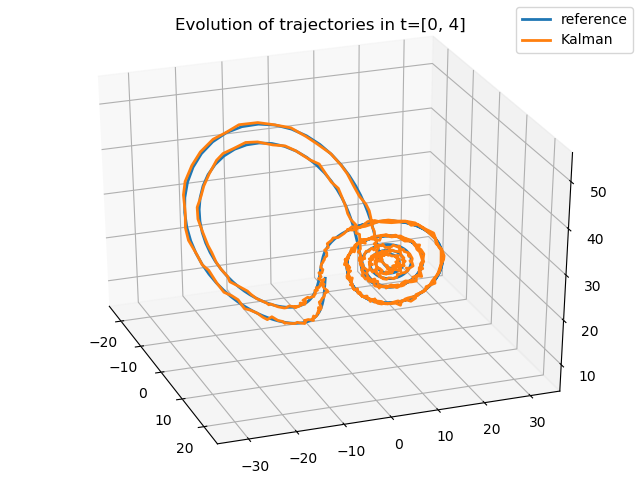

<IPython.core.display.Javascript object>


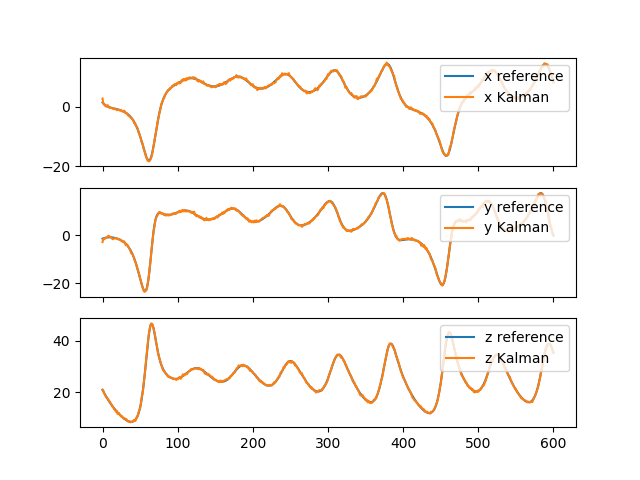

In [12]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('Evolution of trajectories in t=[0, 4]')

x_kal=sum(X_kal)/N
y_kal=sum(Y_kal)/N
z_kal=sum(Z_kal)/N

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_kal = ax.plot(x_kal, y_kal, z_kal, '-')
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_kal, linewidth=2,label='Kalman')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(x_kal, label='x Kalman')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(y_kal, label='y Kalman')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(z_kal, label='z Kalman')
axarr[2].legend(loc="upper right")

The filter has a tendency to diverge because of the accumulation of sampling errors. This problem can be solved empirically by inflating the covariance matrix of the system at each step by a factor $\lambda > 1$:

$$\mathbf P^f \leftarrow \lambda^2 \mathbf P^f$$

In this example, when $N=20$, the filter seems to converge when $\lambda = 3$.

<font color='red'>Check that there is no other reason for divergence (error in the code?...)</font>

## 3.3 Third data assimilation experiment: Variational approaches
Similarly, implement a variational algorithm for the same twin experiments framework. To avoid adjoint coding, consider using a gradient-free minimisation algorithm, such as simulated annealing (see Wikipedia). Feel free to use built-in functions for that (scipy.optimize.anneal in Python).
Similarly provide at least one figure showing reference, background and analysis trajectories over time. Provide also a figure showing the deacrease of the cost function with the iteration number.

In [13]:
from scipy import optimize
np.random.seed(555)   # Seeded to allow replication.

def model(u_inp, sigma, beta, rho, dt):
    """
    Model defined by 3 parameters sigma, beta and rho.
    For a given input state u_inp at time t, returns the state of the system u_mod at time t + dt.
    The model is linearized between t and t + dt.

    Inputs:
    - u_inp (vector of size 3):       state of the system at time t
    - sigma, beta, rho:               model parameters
    - dt:                             time step

    Outputs:
    - u_mod (vector of size 3):       state of the system at time t + dt, by applying the model

    """
    du1 = (sigma * (u_inp[1] - u_inp[0])) * dt
    du2 = (rho * u_inp[0] - u_inp[1] - u_inp[0] * u_inp[2]) * dt
    du3 = (-beta * u_inp[2] + u_inp[0] * u_inp[1]) * dt
    u_mod = u_inp + np.array([du1, du2, du3])
    
    return u_mod


def cost(u_0, u_b, y, P_inv, R_inv, H_inv, sigma, beta, rho, dt):
    """
    Computes the cost function for a given initial state vector, at a given step of the 4D-var algorithm
    
    Inputs:
    - u_0 (vector of size 3):         estimated initial state of the system (on which the cost function is computed)
    - u_b (vector of size 3):         background state vector
    - y (array of shape (T, 3)):      array of observation vectors
    - P_inv (array of shape (3, 3)):  inverse of the background error covariance matrix
    - R_inv (array of shape (3, 3)):  inverse of the observation error covariance matrix
    - H_inv (array of shape (3, 3)):  inverse of the observation operator
    - sigma, beta, rho:               model parameters
    - dt:                             time step
    
    Outputs:
    - j (scalar):                     cost function
    
    """
    T = y.shape[0] # Number of time steps + 1 (includes initial state)
    
    # Initialization
    u = np.zeros((T, 3)) # Array of state vectors
    d = np.zeros((T, 3)) # Array of innovation vectors
    
    u[0] = u_0 # Initial state
    
    # Propagates the model through time
    for k in range(1, T):
        u[k, :] = model(u[k-1], sigma, beta, rho, dt)
    
    # Innovations
    for k in range(T):
        d[k] = y[k] - H_inv.dot(u[k])
    
    # Contributions to the cost function
    j_b = (u_0 - u_b).T.dot(P_inv.dot((u_0 - u_b))) # Contribution of the background
    j_o = 0 # Contribution of the observations
    for k in range(1, res+1):
        j_o = j_o + d[k].T.dot(R_inv.dot(d[k]))
    j_m = 0 # In first appoximation, we suppose that the model is perfect.
    
    j = j_b + j_o + j_m
    return j

 At first we try to find the optimum of our \textit{Lorents mode} using the exact coefficients: $\sigma$, $\beta$ and $\rho$. We do this because we want to understand if our method behaves in the right way, and the reason why we have to use the exact values for the coefficients is because in variational approach we suppose the model to be perfect.

In [52]:
# Initialisation
u_b = np.array([x_b, y_b, z_b])
P = np.eye(3) # Background error covariance matrix
R = np.eye(3) # Observation error covariance matrix
H = np.eye(3) # Observation operator

P_inv = np.linalg.inv(P)
R_inv = np.linalg.inv(R)
H_inv = np.linalg.inv(H)

#u = np.zeros(res+1, 3) # Array of state vectors
#d = np.zeros(res+1, 3) # Array of innovation vectors
y = np.zeros((res+1, 3)) # Array of observation vectors

# Observations
for k in range(res+1):
    y[k] = np.array([x_obs[k], y_obs[k], z_obs[k]])
    
# Initial guess
u_0 = u_b

def cost_0(u_0):
    return cost(u_0, u_b, y, P_inv, R_inv, H_inv,  10.0, 8./3, 28.0, dt)

# Simulated Annealing
ret = optimize.basinhopping(cost_0, u_0, niter=10)

print("global minimum: x = [%.10f, %.2f, %.2f], f(x0) = %.2f" % (ret.x[0],ret.x[1],ret.x[2], ret.fun))
print(u_b)

C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars

global minimum: x = [2.0158815992, -1.81, 21.06], f(x0) = 3.29
[ 3 -3 21]


As we can see in the Figure below, the method that we implemented (with the right choice of parameters) converge to the right solution, which is the same starting point as the observations.

In [53]:
# Model with the new estimated initial value
u = [None] * res
u[0] = u_b

for k in range(1,res):
    u[k] = model(u[k-1], sigma_un, beta_un, rho_un, dt)

<IPython.core.display.Javascript object>


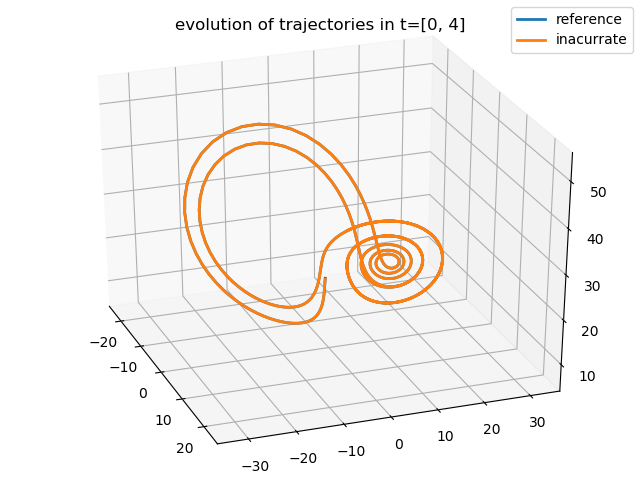

original initial position = [ 3 -3 21]
estimated initial position = [ 2.0158816  -1.805251   21.06121963]


<IPython.core.display.Javascript object>


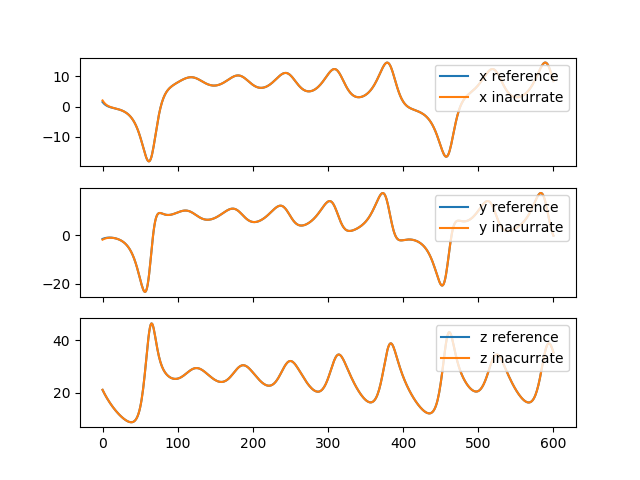

In [54]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('evolution of trajectories in t=[0, 4]')

# Initialization
u_var = np.zeros((res+1, 3)) # Array of state vectors

u_var[0] = ret.x # Initial state

# Propagates the model through time with the right parameters
for k in range(1, res+1):
    u_var[k] = model(u_var[k-1],  10.0, 8./3, 28.0, dt)

print("original initial position =", u[0])
print('estimated initial position =', u_var[0])

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_inac = ax.plot(u_var[:,0], u_var[:,1], u_var[:,2], '-') # CHANGE TO NUMPY ARRAY
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_inac, linewidth=2,label='inacurrate')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(u_var[:,0], label='x inacurrate')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(u_var[:,1], label='y inacurrate')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(u_var[:,2], label='z inacurrate')
axarr[2].legend(loc="upper right")

Now, we  want to see what happens when we use the Variational approach, in which we supposed th model to be perfect
and hence make no error, with a model that in reality is not perfect. In this case, we are going to use the parameters $\sigma_{un}$, $\beta_{un}$ and $\rho_{un}$ nd we want to see what happens to our solutions.

In [65]:
# Initialisation
u_b = np.array([x_b, y_b, z_b])
P = np.eye(3) # Background error covariance matrix
R = np.eye(3) # Observation error covariance matrix
H = np.eye(3) # Observation operator

P_inv = np.linalg.inv(P)
R_inv = np.linalg.inv(R)
H_inv = np.linalg.inv(H)

y = np.zeros((res+1, 3)) # Array of observation vectors

# Observations
for k in range(res+1):
    y[k] = np.array([x_obs[k], y_obs[k], z_obs[k]])
    
# Initial guess
u_0 = u_b

def cost_0(u_0):
    return cost(u_0, u_b, y, P_inv, R_inv, H_inv, sigma_un, beta_un, rho_un, dt)

# Basin Hopping optimization (similiar to Simulated Annealing)
ret = optimize.basinhopping(cost_0, u_0, niter=10)

print("global minimum: x = [%.10f, %.2f, %.2f], f(x0) = %.2f" % (ret.x[0],ret.x[1],ret.x[2], ret.fun))
print(u_b)

C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars

global minimum: x = [2.2974734342, -2.21, 18.42], f(x0) = 72750.65
[ 3 -3 21]


From the Figure below we can see that with an unperfect model and with a low number of iterations (niter$=10$), the method converge to an initial condition which is not too far away from the original one. However, the problem of having having a different model ($rho_{un} = 29$ $\ne$ $28 = \rho$) cause the solution to be inexact for most of the times.

<IPython.core.display.Javascript object>


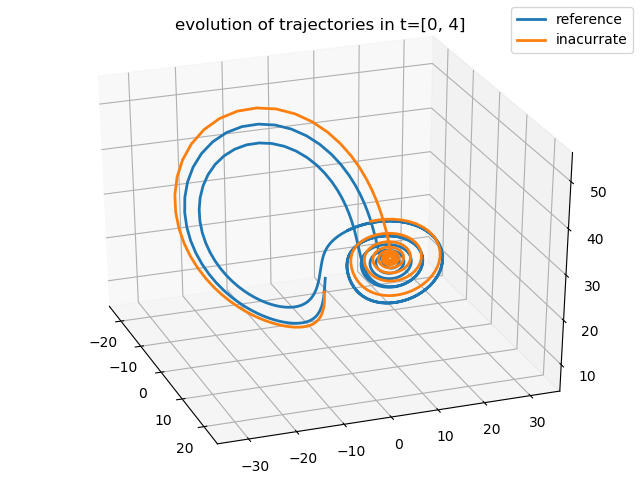

original initial position = [ 3 -3 21]
estimated initial position = [ 2.29747343 -2.20650531 18.41578401]


<IPython.core.display.Javascript object>


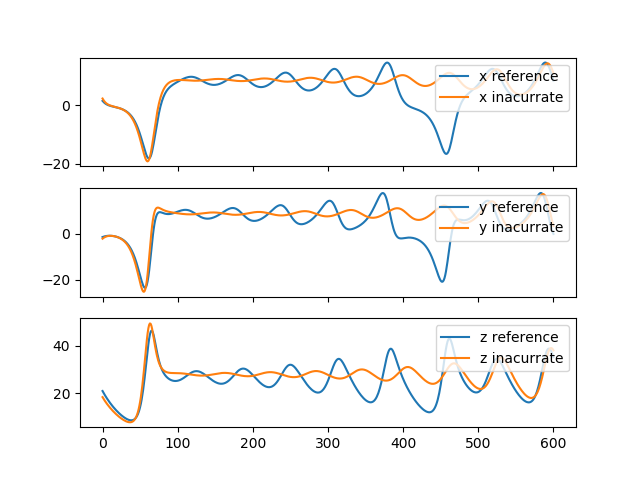

In [66]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('evolution of trajectories in t=[0, 4]')

# Initialization
u_var = np.zeros((res+1, 3)) # Array of state vectors

u_var[0] = ret.x # Initial state

# Propagates the model through time with the right parameters
for k in range(1, res+1):
    u_var[k] = model(u_var[k-1],  sigma_un, beta_un, rho_un, dt)

print("original initial position =", u[0])
print('estimated initial position =', u_var[0])

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_inac = ax.plot(u_var[:,0], u_var[:,1], u_var[:,2], '-') # CHANGE TO NUMPY ARRAY
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_inac, linewidth=2,label='inacurrate')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(u_var[:,0], label='x inacurrate')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(u_var[:,1], label='y inacurrate')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(u_var[:,2], label='z inacurrate')
axarr[2].legend(loc="upper right")

Still, if we increase the number of iterations (niter$=50$), we can check that the overall tajectory will be closer to the observations but the estimated initial point will be totally different.

In [69]:
# Initialisation
u_b = np.array([x_b, y_b, z_b])
P = np.eye(3) # Background error covariance matrix
R = np.eye(3) # Observation error covariance matrix
H = np.eye(3) # Observation operator

P_inv = np.linalg.inv(P)
R_inv = np.linalg.inv(R)
H_inv = np.linalg.inv(H)

y = np.zeros((res+1, 3)) # Array of observation vectors

# Observations
for k in range(res+1):
    y[k] = np.array([x_obs[k], y_obs[k], z_obs[k]])
    
# Initial guess
u_0 = u_b

def cost_0(u_0):
    return cost(u_0, u_b, y, P_inv, R_inv, H_inv,  sigma_un, beta_un, rho_un, dt)

# Basin Hopping optimization (similiar to Simulated Annealing)
ret3 = optimize.basinhopping(cost_0, u_0, niter=50)

print("global minimum: x = [%.10f, %.2f, %.2f], f(x0) = %.2f" % (ret2.x[0],ret2.x[1],ret2.x[2], ret2.fun))
print(u_b)

C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars

global minimum: x = [2.2979607602, -2.21, 18.42], f(x0) = 72750.65
[ 3 -3 21]


<IPython.core.display.Javascript object>


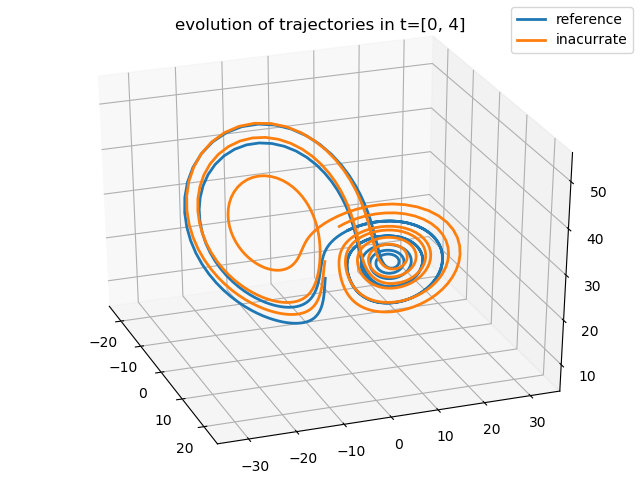

original initial position = [ 3 -3 21]
estimated initial position = [ 1.49538806 -1.58301235 24.77145988]


<IPython.core.display.Javascript object>


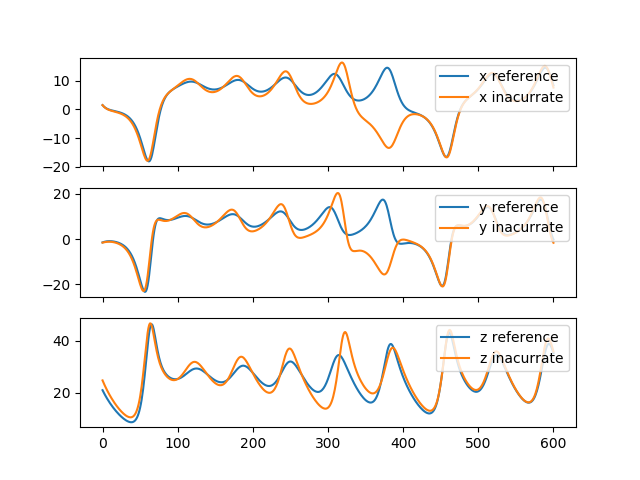

In [71]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('evolution of trajectories in t=[0, 4]')

# Initialization
u_var3 = np.zeros((res+1, 3)) # Array of state vectors
u_var3[0] = ret3.x # Initial state

# Propagates the model through time with the right parameters
for k in range(1, res+1):
    u_var3[k] = model(u_var3[k-1],  sigma_un, beta_un, rho_un, dt)

print("original initial position =", u[0])
print('estimated initial position =', u_var3[0])

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_inac = ax.plot(u_var3[:,0], u_var3[:,1], u_var3[:,2], '-') # CHANGE TO NUMPY ARRAY
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_inac, linewidth=2,label='inacurrate')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(u_var3[:,0], label='x inacurrate')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(u_var3[:,1], label='y inacurrate')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(u_var3[:,2], label='z inacurrate')
axarr[2].legend(loc="upper right")

In [36]:
v = np.zeros(3)
j_b = (v-u_b).T.dot(P_inv.dot((v-u_b)))
j = f(v)
j.shape
j_o = d[k].T.dot(R_inv.dot(d[k]))
y[k]

([2.069334254989946], [-2.0704096019082177], [26.82716441558183])

In [ ]:
u[0].shape

In [ ]:
f(u_0)


## 3.4 additional questions

### Sensitivity of the solutions
For both extended and ensemble Kalman filter, look at :
- the sensitivity of the solution to the errors in the background
- the sensitivity of the solution to the model error Q. What is the impact of excluding the model error correlations ? What is the impact of increasing the magnitude of model error variances ?

Just for the Ensemble Kalman filter, what is the effect of changing :
- the size of the ensemble ?
- the size of the observation perturbation ?

### Less observations
- What happens if observations are not available for every variable (x, y, z) but only for the first variable x? Perform some experiments and provide some figures to illustrate them.
- What happens if observations are not available at every time? Perform some experiments and provide some figures to illustrate them.
- What happens if observations are not exact but corrupted by some (random) measurement errors? Perform some experiments and provide some figures to illustrate them.


In [ ]:
# to be done